In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt

Inizializzo le variabili di interesse e definisco il parametro rho_m.

In [2]:
rho_m = 0.286 * 0.7**2 *2.7751428946e11
M = np.array([10**13.5, 10**14.0, 10**15.0])
c = np.array([2, 5, 10])
z = 0.
R = np.linspace(0.03,1.0,1000)
np.shape(R)

(1000,)

Calcolo r_s sotto forma di matrice 3x3. Ogni entrata contiene il prodotto tra un diverso elemento di 1/c e del termine in radice cubica.

Nota: Le entrate della matrice sono:
    np.outer(a,b) = 
    ([[a1b1, a1b2, a1b3],
      [a2b1, a2b2, a2b3],
      [a3b1, a3b2, a3b3]])

In [3]:
r_s = np.outer(np.cbrt(3 * M / (4 * np.pi * 200 * rho_m * (1+z)**3)), 1/c)

Calcolo rho_s.

In [4]:
f_c = np.log(1 + c) - c / (1 + c)
delta_char = 200 * c**3 / (3 * f_c)
rho_s = rho_m * (1+z)**3 * delta_char

Infine calcolo f(x). x sarà un array 1000x3x3 in cui ogni entrata è funzione di un diverso valore di R,c ed M. Allo stesso modo f sarà una matrice delle stesse dimensioni in cui ogni entrata è la funzione f applicata alla corrispondente entrata di x.

In [5]:
x = np.multiply.outer(R, 1/r_s)
ones = np.ones((1000, 3, 3))

In [6]:
f = np.empty((1000, 3, 3))
for i in range(1000):
    for j in range(3):
        for k in range(3):
            if np.less(x, ones)[i, j, k]:
                f[i, j, k] = (1 - (2 * np.arctanh(np.sqrt((1-x[i, j, k])/(1+x[i, j, k]))) / np.sqrt(1 - x[i, j, k]**2))) / (x[i, j, k]**2 - 1)
            else: 
                if np.greater(x, ones)[i, j, k]:
                    f[i, j, k] = (1 - (2 * np.arctan(np.sqrt((x[i, j, k]-1)/(1+x[i, j, k]))) / np.sqrt(x[i, j, k]**2 - 1))) / (x[i, j, k]**2 - 1)
                else: 
                    f[i, j, k] = 1./3

Il risultato ottenuto è corretto, ma è poco efficiente questa implementazione, perché opera elemento per elemento su 9000 elementi diversi con 3 for innestati uno nell'altro. Posso piuttosto osservare che le funzioni che definiscono f negli intervalli x<1 e x>1 hanno domini disgiunti e utilizzare questo fatto a mio vantaggio.

In [7]:
f1 = (1 - (2 * np.arctanh(np.sqrt((1-x)/(1+x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
f2 = (1 - (2 * np.arctan(np.sqrt((x-1)/(1+x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)
f1[np.isnan(f1)] = 0
f2[np.isnan(f2)] = 0
f = f1 + f2
f = np.where(f == 0., 1./3, f)

C:\Users\Ghigu\AppData\Local\Temp\ipykernel_6440\4161407953.py:1: RuntimeWarning: invalid value encountered in sqrt
  f1 = (1 - (2 * np.arctanh(np.sqrt((1-x)/(1+x))) / np.sqrt(1 - x**2))) / (x**2 - 1)
C:\Users\Ghigu\AppData\Local\Temp\ipykernel_6440\4161407953.py:2: RuntimeWarning: invalid value encountered in sqrt
  f2 = (1 - (2 * np.arctan(np.sqrt((x-1)/(1+x))) / np.sqrt(x**2 - 1))) / (x**2 - 1)


In conclusione posso calcolare Sigma. Sarà una matrice 1000x3x3 in cui il primo indice scorre sugli R, il secondo scorre sugli M e il terzo scorre sui c.

In [8]:
Sigma = 2* rho_s * r_s * f

Ho calcolato tutti i valori di Sigma di mio interesse e procedo a graficarli.

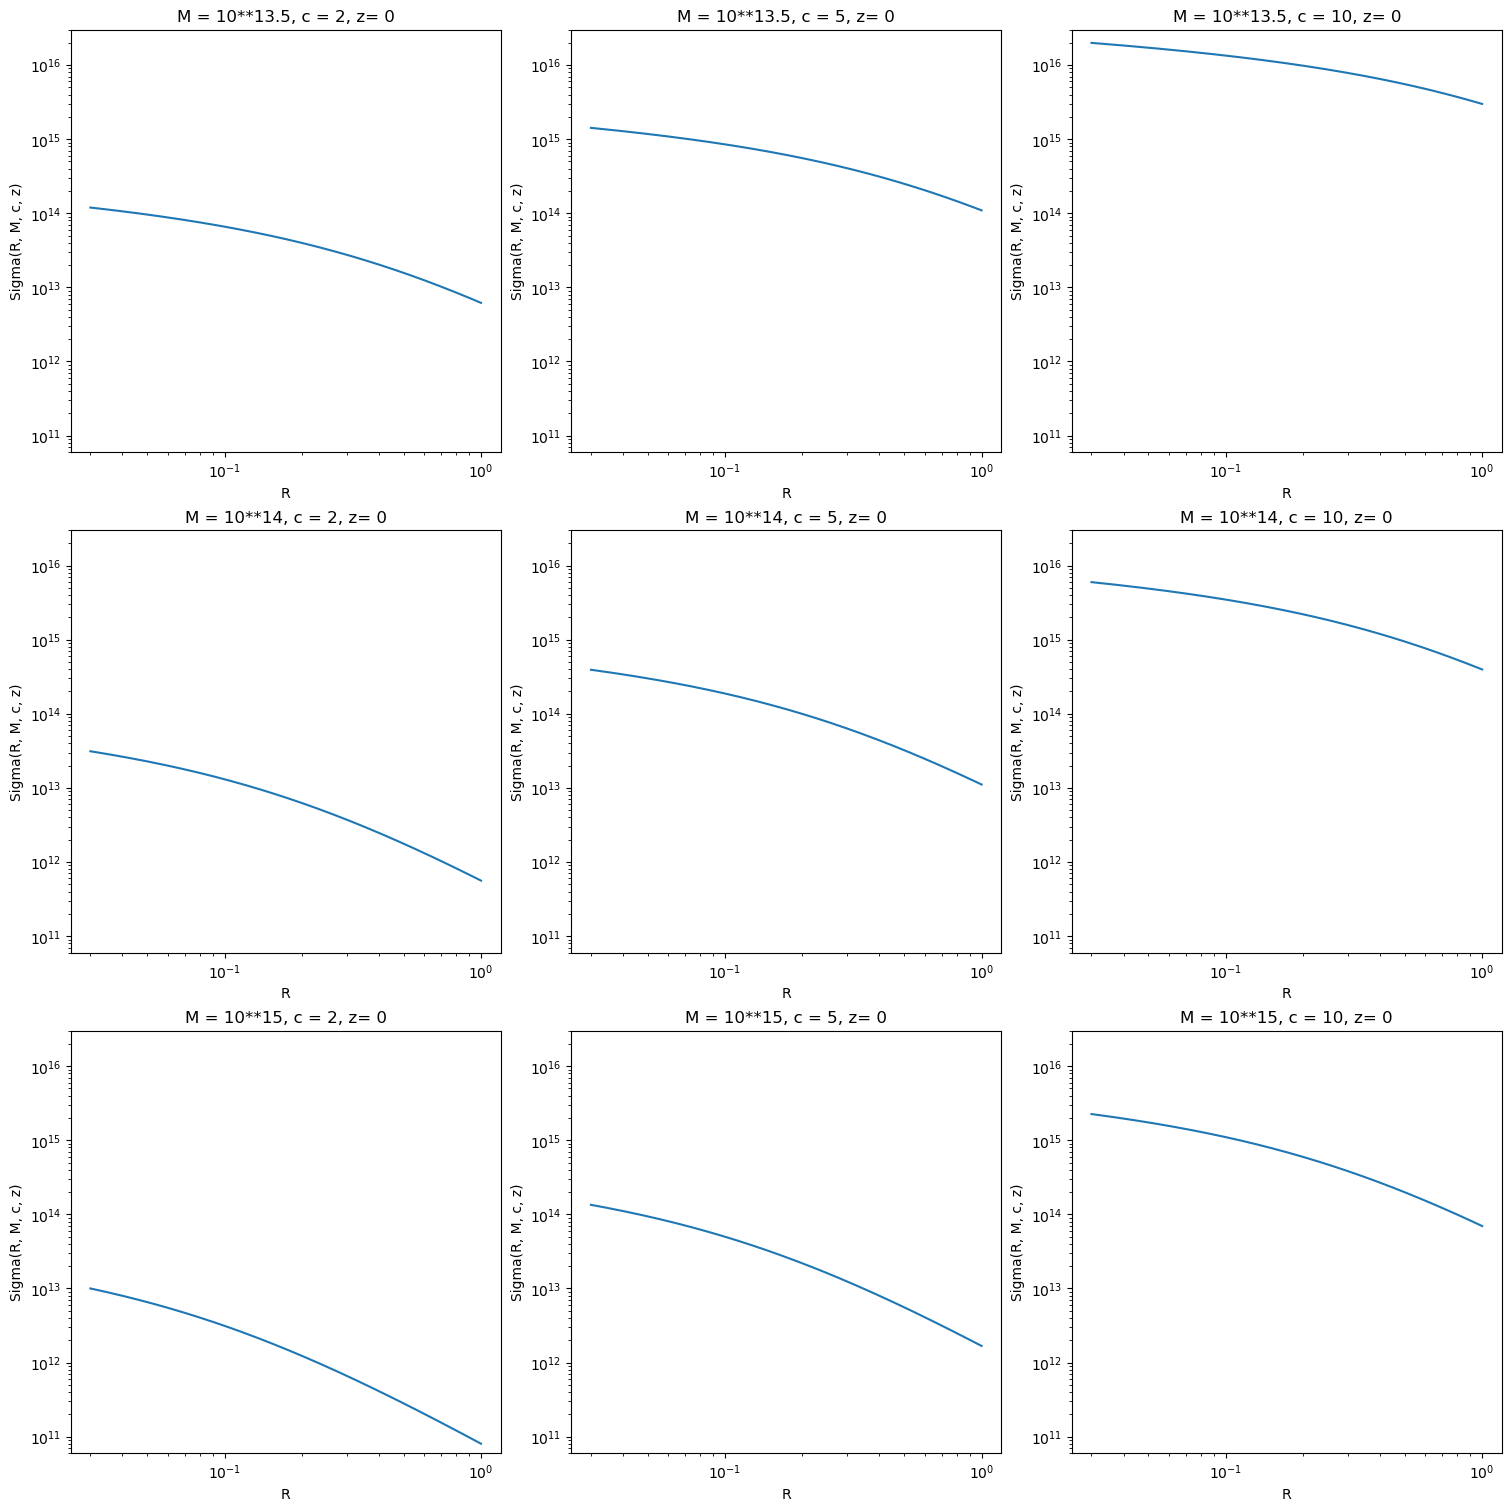

In [59]:
fig, axs = plt.subplots(3, 3, layout = 'constrained')
fig.set_size_inches(15, 15)

axs[0, 0].plot(R, Sigma[:, 0, 0])
axs[0, 0].set_title('M = 10**13.5, c = 2, z= 0')
axs[0, 1].plot(R, Sigma[:, 0, 1])
axs[0, 1].set_title('M = 10**13.5, c = 5, z= 0')
axs[0, 2].plot(R, Sigma[:, 0, 2])
axs[0, 2].set_title('M = 10**13.5, c = 10, z= 0')
axs[1, 0].plot(R, Sigma[:, 1, 0])
axs[1, 0].set_title('M = 10**14, c = 2, z= 0')
axs[1, 1].plot(R, Sigma[:, 1, 1])
axs[1, 1].set_title('M = 10**14, c = 5, z= 0')
axs[1, 2].plot(R, Sigma[:, 1, 2])
axs[1, 2].set_title('M = 10**14, c = 10, z= 0')
axs[2, 0].plot(R, Sigma[:, 2, 0])
axs[2, 0].set_title('M = 10**15, c = 2, z= 0')
axs[2, 1].plot(R, Sigma[:, 2, 1])
axs[2, 1].set_title('M = 10**15, c = 5, z= 0')
axs[2, 2].plot(R, Sigma[:, 2, 2])
axs[2, 2].set_title('M = 10**15, c = 10, z= 0')



for ax in axs.flat:
    ax.set(xlabel = 'R', ylabel = 'Sigma(R, M, c, z)', xscale = 'log', yscale = 'log', ylim = [6e10, 3e16])

Importo i file con i dati

In [ ]:

hdul = fits.open('halo_catalog.fits')

In [ ]:
hdul.info()

Ho trovato che ci sono 2 HDU: Primary e una tabella. La tabella contiene i miei dati, perciò procedo a leggere quella.

In [ ]:
data = hdul[1].data
una_colonna = data[:1]
una_colonna